In [1]:
import pickle
import csv
import math
import pandas as pd
import numpy as np
import os

In [2]:
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [15:18:20] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
from sklearn.preprocessing import KernelCenterer

In [4]:
from scripts.process_dataset.process_DB import get_DB

In [5]:
root = './'

In [6]:
DB_version = "drugbank_v5.1.1"
DB_type = "S0h"
process_name = "NNdti"

In [7]:
dict_ligand, dict_target, intMat, dict_ind2prot, dict_ind2mol, dict_prot2ind, dict_mol2ind = get_DB("drugbank_v5.1.1", 
                                                                                                   "S0h",
                                                                                                   "NNdti")

In [8]:
m = Chem.MolFromSmiles(dict_ligand[dict_ind2mol[1]])

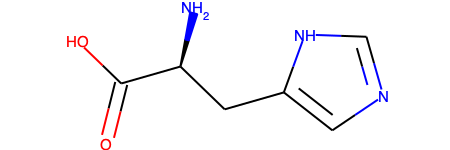

In [16]:
m

In [17]:
AllChem.GetMorganFingerprint(m, 2)

In [18]:
arr = np.zeros((1,))

In [19]:
arr

array([0.])

In [20]:
AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)

In [21]:
DataStructs.ConvertToNumpyArray(
            AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024), arr)

In [22]:
arr

array([0., 1., 0., ..., 0., 0., 0.])

In [24]:
arr.shape

(1024,)

In [31]:
nb_mol = len(list(dict_ligand.keys()))
X_fingerprint = np.zeros((nb_mol, 1024), dtype=np.int32)
list_fingerprint = []
for i in list(dict_ind2mol.keys()):
    m = Chem.MolFromSmiles(dict_ligand[dict_ind2mol[i]])
    list_fingerprint.append(AllChem.GetMorganFingerprint(m, 2))
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(
        AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024), arr)
    X_fingerprint[i, :] = arr
pickle.dump(X_fingerprint,
            open(root + 'data/NNdti_' + DB_type + '_X_ChemFingerprint.data', 'wb'))

In [34]:
X_fingerprint.shape

(4837, 1024)

In [53]:
X = np.zeros((len(list_fingerprint), len(list_fingerprint)))
for i in range(len(list_fingerprint)):
    for j in range(i, len(list_fingerprint)):
        X[i, j] = DataStructs.TanimotoSimilarity(list_fingerprint[i], list_fingerprint[j])
        X[j, i] = X[i, j]

In [54]:
X

array([[1.        , 0.10769231, 0.08064516, ..., 0.08510638, 0.06299213,
        0.07619048],
       [0.10769231, 1.        , 0.27906977, ..., 0.06818182, 0.06956522,
        0.06315789],
       [0.08064516, 0.27906977, 1.        , ..., 0.0625    , 0.08256881,
        0.03225806],
       ...,
       [0.08510638, 0.06818182, 0.0625    , ..., 1.        , 0.12707182,
        0.07692308],
       [0.06299213, 0.06956522, 0.08256881, ..., 0.12707182, 1.        ,
        0.12328767],
       [0.07619048, 0.06315789, 0.03225806, ..., 0.07692308, 0.12328767,
        1.        ]])

In [37]:
def center_and_normalise_kernel(K_temp):
    K_temp = KernelCenterer().fit_transform(K_temp)
    nb_item = K_temp.shape[0]
    K_norm = np.zeros((nb_item, nb_item))
    for i in range(nb_item):
        for j in range(i, nb_item):
            K_norm[i, j] = K_temp[i, j] / math.sqrt(K_temp[i, i] * K_temp[j, j])
            K_norm[j, i] = K_norm[i, j]

    return K_norm

In [60]:
K_norm = center_and_normalise_kernel(X)

In [61]:
K_norm

array([[ 1.00000000e+00,  4.05812889e-02,  2.09262664e-02, ...,
        -1.07224215e-02, -4.91870455e-02, -3.19845198e-02],
       [ 4.05812889e-02,  1.00000000e+00,  2.35747010e-01, ...,
        -2.45615717e-02, -3.68363298e-02, -4.15551754e-02],
       [ 2.09262664e-02,  2.35747010e-01,  1.00000000e+00, ...,
        -2.07657007e-02, -1.22324163e-02, -6.53496980e-02],
       ...,
       [-1.07224215e-02, -2.45615717e-02, -2.07657007e-02, ...,
         1.00000000e+00, -4.37988527e-04, -5.53925117e-02],
       [-4.91870455e-02, -3.68363298e-02, -1.22324163e-02, ...,
        -4.37988527e-04,  1.00000000e+00, -1.64196311e-02],
       [-3.19845198e-02, -4.15551754e-02, -6.53496980e-02, ...,
        -5.53925117e-02, -1.64196311e-02,  1.00000000e+00]])

In [49]:
np.max(K_norm)

1.0

In [59]:
np.argmax(X, axis=1)

array([   0,    1,    2, ..., 4834, 4835, 4836])

In [46]:
X

[[1.0, -2.0, 2.0], [-2.0, 1.0, 3.0], [4.0, 1.0, -2.0]]

In [47]:
transformer = KernelCenterer().fit(K)

NameError: name 'K' is not defined

In [62]:
print(X[100, 100], K_norm[100, 100])

1.0 1.0


In [63]:
print(X[100, :], K_norm[100, :])

[0.09016393 0.06140351 0.05454545 ... 0.10382514 0.14285714 0.265625  ] [-0.01970001 -0.04691819 -0.04415861 ... -0.0280698   0.00288916
  0.14777339]


In [64]:
print(X[500, 500], K_norm[500, 500])

1.0 1.0


In [65]:
print(X[500, :], K_norm[500, :])

[0.03030303 0.03783784 0.07471264 ... 0.11885246 0.07594937 0.00431034] [-0.01107849  0.00126058  0.04839051 ...  0.06122819  0.00257918
 -0.07251242]
